In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/dependent_gen/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, 10):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.177 (1.177)	Loss 0.6986 (0.6986)	Accuracy 0.5312 (0.5312)
Batch: [10/40]	Time 0.048 (0.178)	Loss 0.5440 (0.6345)	Accuracy 0.7500 (0.6619)
Batch: [20/40]	Time 0.356 (0.184)	Loss 0.4947 (0.5815)	Accuracy 0.7188 (0.6972)
Batch: [30/40]	Time 0.060 (0.177)	Loss 0.4306 (0.5356)	Accuracy 0.8359 (0.7324)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.737 (0.737)	Loss 0.6877 (0.6877)	Accuracy 0.7109 (0.7109)
Avg validation loss: 0.525038339138031 	 Accuracy: 0.784
--------------------
Epoch 0/20	Time 7.646 sec (7.646 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.882 (0.882)	Loss 0.4026 (0.4026)	Accuracy 0.8281 (0.8281)
Batch: [10/40]	Time 0.036 (0.201)	Loss 0.3616 (0.4099)	Accuracy 0.8516 (0.8168)
Batch: [20/40]	Time 0.507 (0.194)	Loss 0.4885 (0.4076)	Accuracy 0.7891 (0.8229)
Batch: [30/40]	Time 0.046 (0.177)	Loss 0.4870 (0.3996)	Accuracy 0.8281 (0.8301)
----------
Test: [0/4]	Time 0.783 (0.783)	Loss 0.4545 (0.4545)	Accuracy 0.7891 (0.7891)
Avg validation loss: 0.39984362316131594 	 Accuracy: 0.826
--------------------
Epoch 1/20	Time 7.616 sec (7.631 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.822 (0.822)	Loss 0.3221 (0.3221)	Accuracy 0.8750 (0.8750)
Batch: [10/40]	Time 0.037 (0.202)	Loss 0.4236 (0.3430)	Accuracy 0.8281 (0.8544)
Batch: [20/40]	Time 0.464 (0.193)	Loss 0.3834 (0.3312)	Accuracy 0.8516 (0.8624)
Batch: [30/40]	Time 0.072 (0.177)	Loss 0.2400 (0.3237)	Accuracy 0.9062 (0.8664)
----------
Test: [0/4]	Time 0.800 (0.800)	Loss 0.4161 (0.4161)	Accuracy 0.8438 (0.8438)
Avg validation loss: 0.347195588350

In [16]:
import matplotlib.pyplot as plt

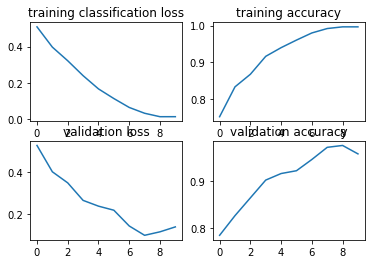

In [17]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [18]:
from synthetic_dataloader import *

In [19]:
shape_gender_train = ShapeGenderDataset(train_df)
shape_gender_val = ShapeGenderDataset(val_df)
shape_gender_test = ShapeGenderDataset(test_df)

In [20]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(train_df)):
        img, shape, color = shape_gender_train[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [21]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [22]:
import matplotlib.cm as cm
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.style.use('bmh')

In [23]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [25]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [26]:
train_df.class_to_idx

{'circle': 0, 'rectangle': 1}

Saved to: dep_tsne_train_classifier_y.pdf


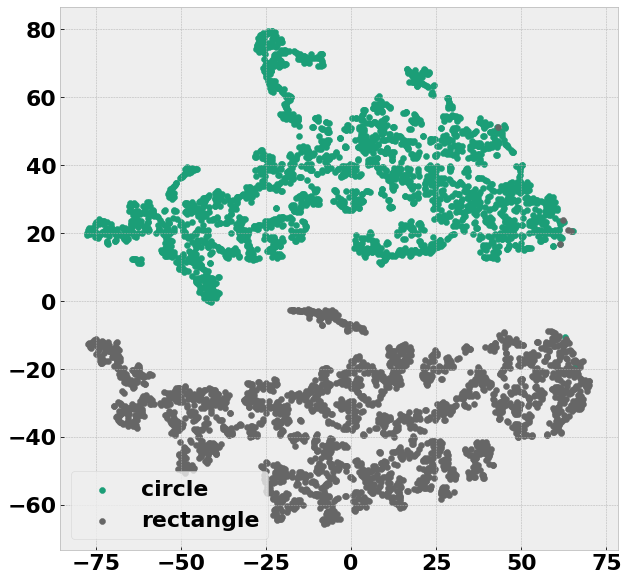

In [27]:
plt.figure(figsize=(10, 10))
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
out = "dep_tsne_train_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))
# plt.show()

Saved to: dep_tsne_train_classifier_s.pdf


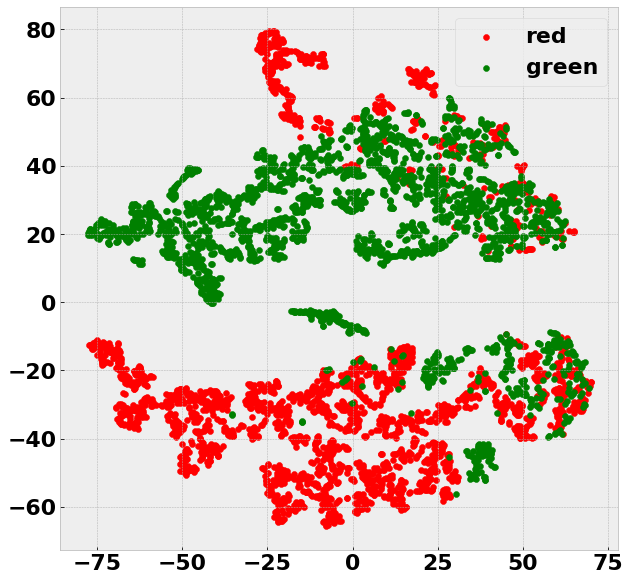

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "dep_tsne_train_classifier_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))
# plt.show()

In [29]:
reps_test = []
shapes_test = []
colors_test= []
encoder.eval()
with torch.no_grad():
    for i in range(len(test_df)):
        img, shape, color = shape_gender_test[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps_test.append(encoding[0].cpu().numpy())
        shapes_test.append(shape)
        colors_test.append(color)
        if i == 0: 
            print(i)

0


In [30]:
y_num_test = pd.DataFrame(shapes_test)
s_test = pd.DataFrame(colors_test)
X_test = pd.DataFrame(reps_test)

In [31]:
X_pca_test = PCA(n_components=50).fit_transform(X_test, X_test)
tsne_test = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r_test = tsne.fit_transform(X_pca_test)

In [32]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

Saved to: dep_tsne_test_classifier_y.pdf


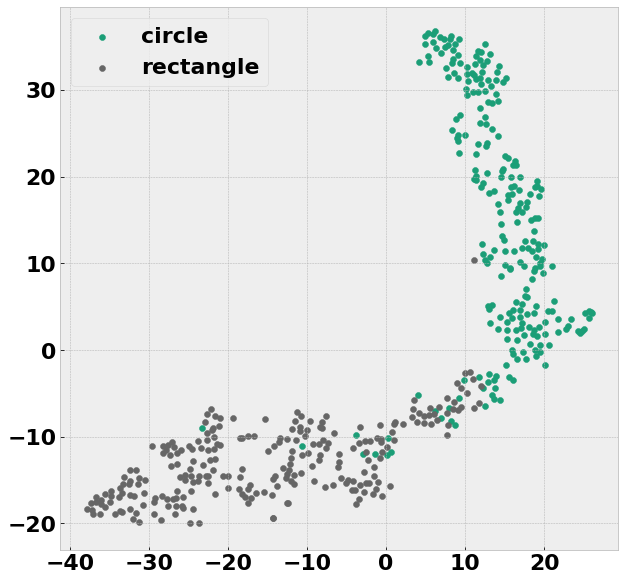

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(X_r_test[(y_num_test == 0)[0], 0], X_r_test[(y_num_test == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r_test[(y_num_test == 1)[0], 0], X_r_test[(y_num_test == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
out = "dep_tsne_test_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: dep_tsne_test_classifier_s.pdf


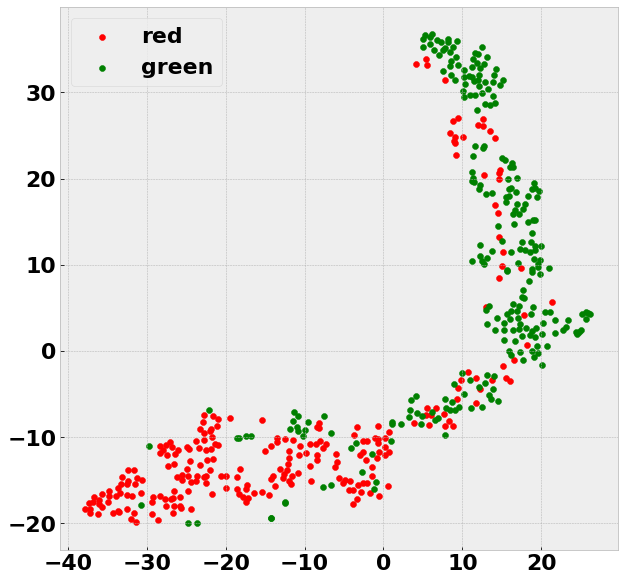

In [36]:
plt.figure(figsize=(10, 10))
plt.scatter(X_r_test[(s_test == 1)[0], 0], X_r_test[(s_test == 1)[0], 1], c='red', label='red')
plt.scatter(X_r_test[(s_test == 0)[0], 0], X_r_test[(s_test == 0)[0], 1], c='green', label='green')
plt.legend()
out = "dep_tsne_test_classifier_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))